# Capstone Project - Week 3
## Cleansing data

In [1]:
#import libraries
import pandas as pd
import numpy as np

In [2]:
#scrape wiki table
dfs = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
print(len(dfs))

3


In [3]:
df = dfs[0]

In [4]:
#df

In [5]:
#create one column and drop the variable column
df2 = df.melt()
df2.drop(columns="variable",inplace=True)

#slice the first 3 characters of 'value' to create the PostalCode
df2['PostalCode']=df2['value'].str.slice(stop=3)
#remove the first three characters from 'value' as they have now been copied to a new column
df2['value'] = df2['value'].str[3:]

#split the column 'value' into 'Borough' and 'Neighborhood' based on the parantheses
df2[['Borough','Neighborhood']] = df2.value.str.split('\(|\)', expand=True).iloc[:,[0,1]]

#drop the value column as all relevant data has been extracted
df2.drop(columns="value",inplace=True)

#replace'/' with ',' in the column 'Neighborhood'
df2['Neighborhood'] = df2['Neighborhood'].str.replace(' /',',')

#df2

In [6]:
#Requirement: Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
#remove all postal codes with no boroughs
df3 = df2[df2.Borough != 'Not assigned']

#reset the index
df3 = df3.reset_index(drop=True)

#pd.set_option('display.max_rows', None)

#df3

In [7]:
#Requirement: More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma. 
#ensure postal codes are unique 

#index = df3.index
#print("The number of rows in the data frame is:", len(index))
#print("The number of unique values for the postal code is:", df3['PostalCode'].nunique() )

df4 = df3.groupby('PostalCode').agg(lambda x: ', '.join(set(x))).reset_index()

#df4

index2 = df4.index
print("The number of rows in the data frame is:", len(index2))
print("The number of unique values for the postal code is:", df4['PostalCode'].nunique() )

The number of rows in the data frame is: 103
The number of unique values for the postal code is: 103


In [8]:
#Requirement: If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough.
#check if any neighborhoods are 'Not assigned'

df4.loc[df4['Neighborhood'] == "Not assigned", 'Neighborhood'] = df3['Borough']
print("Number of neighborhoods that are not assigned:", len(df3.loc[df3['Neighborhood'] == "Not assigned"]))
df4

Number of neighborhoods that are not assigned: 0


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [9]:
#Requirement: In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

df4.shape

(103, 3)

## Adding langitude and longitude details

In [10]:
loc = pd.read_csv("https://cocl.us/Geospatial_data")

In [11]:
loc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
df4.columns = ['Postal Code', 'Borough', 'Neighborhood']
df_merge = pd.merge(df4, loc, on='Postal Code', how='inner')
df_merge

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


# Exploration and Clustering

In [13]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!pip install --upgrade pandas

In [14]:
#getting Toronto coordinates

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto is {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Toronto is 43.6534817, -79.3839347.


In [15]:
# create map of Torronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

neighborhoods = df_merge

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [16]:
#exploring Toronto through Foursquare
CLIENT_ID = 'SRMPT4L3BCR5EJFDHVC2BO3OQ555NGCFEIZYO4PZHDHTD1KB' # your Foursquare ID
CLIENT_SECRET = '0REPJIWMIAUK25KRSVJXNQSYE1XFJSPFRCQ3C4DDMBL3GRR4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SRMPT4L3BCR5EJFDHVC2BO3OQ555NGCFEIZYO4PZHDHTD1KB
CLIENT_SECRET:0REPJIWMIAUK25KRSVJXNQSYE1XFJSPFRCQ3C4DDMBL3GRR4


In [17]:
# getting information on first neighborhood

neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # Borough name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.8066863, -79.1943534.


In [18]:
#getting venues for first neighborhood

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=SRMPT4L3BCR5EJFDHVC2BO3OQ555NGCFEIZYO4PZHDHTD1KB&client_secret=0REPJIWMIAUK25KRSVJXNQSYE1XFJSPFRCQ3C4DDMBL3GRR4&v=20180605&ll=43.8066863,-79.1943534&radius=500&limit=100'

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6052c826303bbd47528fbdb8'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.811186304500005,
    'lng': -79.1881295807304},
   'sw': {'lat': 43.8021862955, 'lng': -79.20057721926959}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'dis

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
#get all information on venue(s)

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


### Get all venues from all neighborhoods

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
torronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawre

In [26]:
print(torronto_venues.shape)
torronto_venues.head()

(2124, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


In [27]:
# condense to number of neighborhoods
torronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Wexford, Maryvale",5,5,5,5,5,5
Willowdale,39,39,39,39,39,39
Woburn,4,4,4,4,4,4


In [28]:
print('There are {} uniques categories.'.format(len(torronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


In [76]:
torronto_venues['Venue Category']

0       Fast Food Restaurant
1                        Bar
2                       Bank
3          Electronics Store
4                 Restaurant
                ...         
2119            Liquor Store
2120     Rental Car Location
2121               Drugstore
2122           Garden Center
2123              Truck Stop
Name: Venue Category, Length: 2124, dtype: object

### Analyze neighborhoods

In [89]:
# one hot encoding
torronto_onehot = pd.get_dummies(torronto_venues[['Venue Category']], prefix="", prefix_sep="")


#my_list = list(torronto_onehot)

#my_list

# add neighborhood column back to dataframe
torronto_onehot['Neighborhood'] = torronto_venues['Neighborhood'] 

#np.unique(torronto_onehot['Neighborhood'].values)

torronto_onehot.dtypes


Accessories Store     uint8
Adult Boutique        uint8
Airport               uint8
Airport Food Court    uint8
Airport Gate          uint8
                      ...  
Wine Bar              uint8
Wine Shop             uint8
Wings Joint           uint8
Women's Store         uint8
Yoga Studio           uint8
Length: 270, dtype: object

In [145]:

# move neighborhood column to the first column
fixed_columns = [torronto_onehot.columns[-1]] + list(torronto_onehot.columns[:-1])
torronto_onehot = torronto_onehot[fixed_columns]

torronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
torronto_onehot.shape

(2124, 270)

In [91]:
#group by neighborhoods and use the mean to calculate the merged scores

torronto_grouped = torronto_onehot.groupby('Neighborhood').mean().reset_index()
torronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"Wexford, Maryvale",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0
91,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
92,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
torronto_grouped.shape

(94, 270)

In [93]:
#Find top 5 venues for each neighborhood

num_top_venues = 5

for hood in torronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = torronto_grouped[torronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4          Accessories Store  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2    Dance Studio  0.14
3             Pub  0.14
4  Sandwich Place  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop  0.09
2                   Pharmacy  0.04
3                      Diner  0.04
4  Middle Eastern Restaurant  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4        Movie Theater  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.09
1      Sandwich Place  0.09

                venue  freq
0               Field  0.25
1             Dog Run  0.25
2        Hockey Arena  0.25
3               Trail  0.25
4  Miscellaneous Shop  0.00


----India Bazaar, The Beaches West----
                  venue  freq
0  Fast Food Restaurant  0.11
1               Brewery  0.06
2     Food & Drink Shop  0.06
3      Sushi Restaurant  0.06
4         Movie Theater  0.06


----Kennedy Park, Ionview, East Birchmount Park----
                venue  freq
0          Hobby Shop  0.17
1   Convenience Store  0.17
2      Discount Store  0.17
3  Chinese Restaurant  0.17
4         Coffee Shop  0.17


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.05
3             Mexican Restaurant  0.05
4          Vietnamese Restaurant  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                   ve

----The Danforth West, Riverdale----
                    venue  freq
0        Greek Restaurant  0.19
1             Coffee Shop  0.09
2      Italian Restaurant  0.07
3  Furniture / Home Store  0.05
4               Bookstore  0.05


----The Kingsway, Montgomery Road, Old Mill North----
                 venue  freq
0                 Pool   0.5
1                River   0.5
2    Accessories Store   0.0
3   Miscellaneous Shop   0.0
4  Moroccan Restaurant   0.0


----Thorncliffe Park----
               venue  freq
0     Sandwich Place  0.09
1  Indian Restaurant  0.09
2        Yoga Studio  0.05
3       Intersection  0.05
4        Pizza Place  0.05


----Toronto Dominion Centre, Design Exchange----
         venue  freq
0  Coffee Shop  0.11
1        Hotel  0.07
2         Café  0.06
3   Restaurant  0.04
4  Salad Place  0.03


----University of Toronto, Harbord----
                 venue  freq
0                 Café  0.19
1                  Bar  0.06
2  Japanese Restaurant  0.06
3            Books

In [94]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:
#return top 10 most common venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torronto_grouped['Neighborhood']

for ind in np.arange(torronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Accessories Store,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Dance Studio,Pub,Sandwich Place,Coffee Shop,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Men's Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Diner,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Fried Chicken Joint,Supermarket,Frozen Yogurt Shop
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Accessories Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Toy / Game Store,Pharmacy,Butcher,Café,Liquor Store,Sushi Restaurant,Juice Bar
...,...,...,...,...,...,...,...,...,...,...,...
89,"Wexford, Maryvale",Auto Garage,Bakery,Middle Eastern Restaurant,Smoke Shop,Sandwich Place,Accessories Store,Modern European Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant
90,Willowdale,Ramen Restaurant,Pizza Place,Coffee Shop,Sushi Restaurant,Café,Sandwich Place,Japanese Restaurant,Grocery Store,Middle Eastern Restaurant,Juice Bar
91,Woburn,Coffee Shop,Convenience Store,Korean BBQ Restaurant,Accessories Store,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
92,Woodbine Heights,Dance Studio,Skating Rink,Intersection,Park,Beer Store,Video Store,Curling Ice,Athletics & Sports,Monument / Landmark,Molecular Gastronomy Restaurant


### Cluster neighborhoods

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline 

torronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)

torronto_grouped_clustering


,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# run k-means clustering on number of k to find optimal k
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(torronto_grouped_clustering)
    distortions.append(kmeans.inertia_)



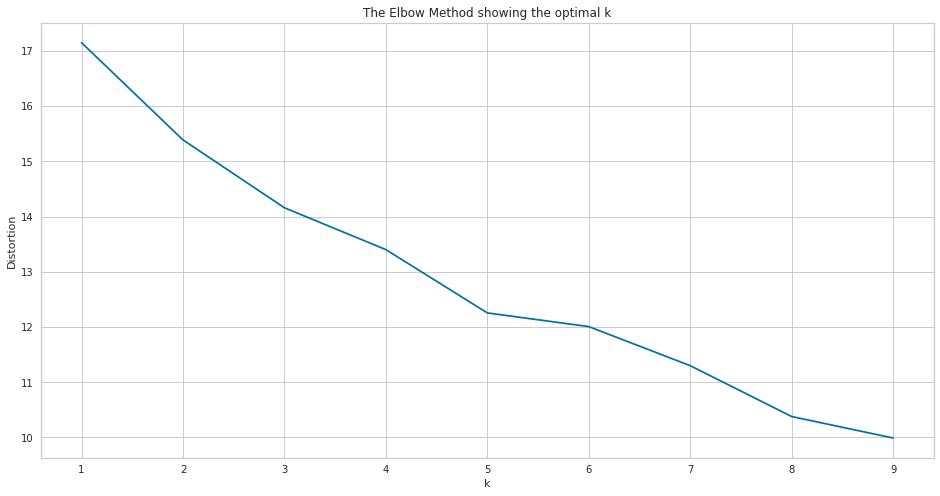

In [135]:
#plot k to identify elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# check cluster labels generated for each row in the dataframe


In [136]:
# set number of clusters to 5 based on elbow chart
kclusters = 5

torronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torronto_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [137]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#neighborhoods_venues_sorted

#neighborhoods_venues_sorted.dtypes 
#neighborhoods
#torronto_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
torronto_merged = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how="inner")

torronto_merged
#torronto_merged.dtypes
#np.unique(torronto_merged['Cluster Labels'].values)

#torronto_merged.astype({"Cluster Labels":int})

torronto_merged


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2,Fast Food Restaurant,Accessories Store,Motel,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Bar,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Market
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Medical Center,Mexican Restaurant,Bank,Intersection,Restaurant,Rental Car Location,Electronics Store,Breakfast Spot,Middle Eastern Restaurant,Miscellaneous Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Convenience Store,Korean BBQ Restaurant,Accessories Store,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Thai Restaurant,Bank,Caribbean Restaurant,Gas Station,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bakery,Modern European Restaurant,Moroccan Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,0,Park,Accessories Store,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,1,Pizza Place,Middle Eastern Restaurant,Intersection,Chinese Restaurant,Sandwich Place,Coffee Shop,Discount Store,Miscellaneous Shop,Mexican Restaurant,Metro Station
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,1,Pizza Place,Park,Bus Line,Sandwich Place,Performing Arts Venue,Pet Store,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,1,Grocery Store,Pizza Place,Liquor Store,Fried Chicken Joint,Sandwich Place,Beer Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Men's Store


In [138]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(torronto_merged['Latitude'], torronto_merged['Longitude'], torronto_merged['Neighborhood'], torronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine clusters

In [139]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 0, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0,Playground,Park,Intersection,Pharmacy,Motel,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station
23,North York,0,Convenience Store,Park,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Metro Station
25,North York,0,Convenience Store,Park,Food & Drink Shop,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
40,East YorkEast Toronto,0,Park,Intersection,Convenience Store,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
48,Central Toronto,0,Playground,Park,Trail,Tennis Court,Medical Center,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Moroccan Restaurant
50,Downtown Toronto,0,Park,Playground,Trail,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
64,Central Toronto,0,Sushi Restaurant,Jewelry Store,Park,Trail,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Accessories Store
98,York,0,Park,Accessories Store,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant


This cluster seems to group neighbourhoods that have a lot of nature (ie Parks) 

In [140]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 1, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1,Bar,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Market
2,Scarborough,1,Medical Center,Mexican Restaurant,Bank,Intersection,Restaurant,Rental Car Location,Electronics Store,Breakfast Spot,Middle Eastern Restaurant,Miscellaneous Shop
3,Scarborough,1,Coffee Shop,Convenience Store,Korean BBQ Restaurant,Accessories Store,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,Scarborough,1,Thai Restaurant,Bank,Caribbean Restaurant,Gas Station,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bakery,Modern European Restaurant,Moroccan Restaurant
5,Scarborough,1,Playground,Grocery Store,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station
...,...,...,...,...,...,...,...,...,...,...,...,...
96,North York,1,Pizza Place,Construction & Landscaping,Intersection,Pharmacy,Motel,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station
99,Etobicoke,1,Pizza Place,Middle Eastern Restaurant,Intersection,Chinese Restaurant,Sandwich Place,Coffee Shop,Discount Store,Miscellaneous Shop,Mexican Restaurant,Metro Station
100,Etobicoke,1,Pizza Place,Park,Bus Line,Sandwich Place,Performing Arts Venue,Pet Store,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store
101,Etobicoke,1,Grocery Store,Pizza Place,Liquor Store,Fried Chicken Joint,Sandwich Place,Beer Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Men's Store


This cluster seems to focus on restaurant and bars

In [141]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 2, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2,Fast Food Restaurant,Accessories Store,Motel,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
63,Central Toronto,2,Fast Food Restaurant,Home Service,Garden,Medical Center,Mediterranean Restaurant,Massage Studio,Men's Store,Metro Station,Motel,Middle Eastern Restaurant


This cluster is focused on neighborhoods with lots of fast food restaurants.

In [142]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 3, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Etobicoke,3,Bakery,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Market


This cluster seems focused on a single neighborhood with a lot of bakeries.

In [143]:
torronto_merged.loc[torronto_merged['Cluster Labels'] == 4, torronto_merged.columns[[1] + list(range(5, torronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,4,Construction & Landscaping,Baseball Field,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant
97,North York,4,Baseball Field,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Market


This cluster groups neighborhoods with Baseball Fields.